In [1]:
import sys
import os

# 현재 notebook 디렉토리 경로를 얻어옴
notebook_dir = os.path.abspath('')

# package 폴더의 상위 디렉토리를 경로에 추가
sys.path.append(os.path.join(notebook_dir, '..'))

# 경로가 제대로 추가되었는지 확인 (디버깅용)
print(sys.path)

# 이제 모듈을 임포트 할 수 있습니다.
from source.package.DataLoader import DataLoader

['/home/changbae/anaconda3/envs/fmrienv/lib/python39.zip', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/lib-dynload', '', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages', '/home/changbae/fmri_project/MDMR/notebook/..']


In [2]:

# 경로 설정 등 추가 코드
source_dir = "/mnt/NAS2/data/SAD_gangnam_resting/fMRIPrep"
gray_matter_mask_path = "/home/changbae/fmri_project/MDMR/template/tpl-MNI152NLin2009cAsym_space-MNI_res-01_class-GM_probtissue.nii"

data_loader = DataLoader()
subject_codes = data_loader.get_subject_codes(source_dir)


In [3]:
fmri = data_loader.load_fmri(subject_code=subject_codes[0])

In [4]:
masked_data, binary_gray_matter_mask = data_loader.apply_gray_matter_mask(
    fmri_img=fmri
)

In [5]:
masked_data.shape

(152, 14467)

Original fMRI shape: (42, 52, 35)


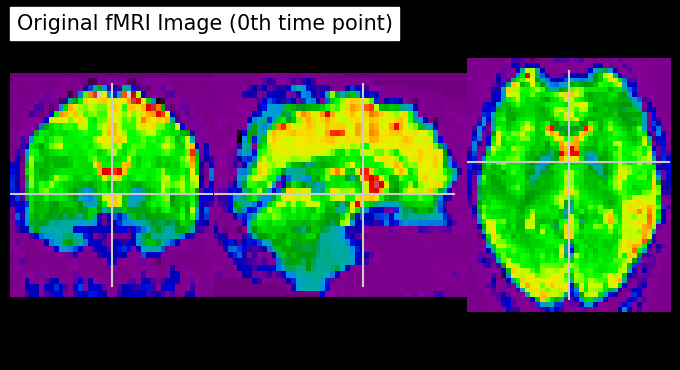

In [7]:
from nilearn.image import resample_to_img, new_img_like, index_img
from nilearn import image, masking, plotting
import matplotlib.pyplot as plt
# 첫 번째 시간 포인트에서 원래 fMRI 데이터
fmri_img_3d = index_img(fmri, 0)
print(f"Original fMRI shape: {fmri_img_3d.shape}")

# 첫 번째 시간 포인트에서 원래 fMRI 데이터 플롯
plotting.plot_epi(fmri_img_3d, title="Original fMRI Image (0th time point)", display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True, annotate=False)

Masked fMRI shape: (42, 52, 35)


<Figure size 1200x600 with 0 Axes>

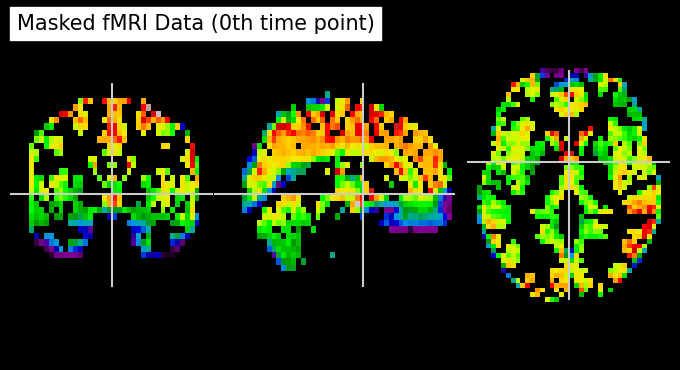

In [8]:
masked_img_4d = masking.unmask(masked_data, binary_gray_matter_mask)

# 첫 번째 시간 포인트에서 masked_data를 3D 이미지로 변환
masked_img_3d = index_img(masked_img_4d, 0)
print(f"Masked fMRI shape: {masked_img_3d.shape}")

# 첫 번째 시간 포인트에서 masked_data 플롯
plt.figure(figsize=(12, 6))
plotting.plot_epi(masked_img_3d, title="Masked fMRI Data (0th time point)", display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True, annotate=False)
plt.show()

In [17]:
import numpy as np
mask_data = masked_img_3d.get_fdata()
coords = np.column_stack(np.where(mask_data))
masked_data.shape

(152, 14467)

In [15]:
voxel_time_series = masked_data[:, 0]
voxel_time_series.shape

(152,)

In [16]:
other_voxels_data = np.delete(masked_data, 0, axis=1)
other_voxels_data.shape

(152, 14466)

In [18]:
correlation_vector = np.array([
    np.corrcoef(voxel_time_series, other_voxel_time_series)[0, 1]
    for other_voxel_time_series in other_voxels_data.T
])
    
correlation_vector.shape

(14466,)

In [20]:
correlation_vector

array([-0.23450021, -0.18645815,  0.21771744, ...,  0.26262646,
       -0.29194363,  0.00995813])

In [1]:
import sys
import os
import numpy as np

# 현재 notebook 디렉토리 경로를 얻어옴
notebook_dir = os.path.abspath('')

# package 폴더의 상위 디렉토리를 경로에 추가
sys.path.append(os.path.join(notebook_dir, '..'))

# 경로가 제대로 추가되었는지 확인 (디버깅용)
print(sys.path)

from tqdm import tqdm
# 이제 모듈을 임포트 할 수 있습니다.
from source.package.DataLoader import DataLoader
from source.package.StatHandler import StatHandler
import concurrent.futures
data_loader = DataLoader(source_dir = "/mnt/NAS2/data/SAD_gangnam_resting/fMRIPrep")
stat_handler = StatHandler()
subject_codes = data_loader.get_subject_codes()

with concurrent.futures.ThreadPoolExecutor() as executor:
    future1 = executor.submit(data_loader.load_fmri, subject_code=subject_codes[0])
    future2 = executor.submit(data_loader.load_fmri, subject_code=subject_codes[1])
    fmri_1 = future1.result()
    fmri_2 = future2.result()

masked_data_1, binary_gray_matter_mask, coords = data_loader.apply_gray_matter_mask(
    fmri_img=fmri_1
)
masked_data_2, binary_gray_matter_mask, coords = data_loader.apply_gray_matter_mask(
    fmri_img=fmri_2
)

common_nonzero_mask = np.load("/home/changbae/fmri_project/MDMR/template/common_mask_as_np.npy")

# common_nonzero_mask를 사용하여 관심 복셀을 찾음
filtered_masked_data_1 = masked_data_1[:, common_nonzero_mask]
print(f"GM masked data shape: {masked_data_1.shape}")
print(f"Filtered masked data shape: {filtered_masked_data_1.shape}")

# common_nonzero_mask를 사용하여 관심 복셀을 찾음
filtered_masked_data_2 = masked_data_2[:, common_nonzero_mask]
print(f"GM masked data shape: {masked_data_2.shape}")
print(f"Filtered masked data shape: {filtered_masked_data_2.shape}")

nonzero_coords = coords[common_nonzero_mask]

shape = fmri_1.shape

corr_sub_1_vox_0 = stat_handler.temporal_correlation_by_voxel(
    masked_data=filtered_masked_data_1,
    index=0
)
corr_sub_2_vox_0 = stat_handler.temporal_correlation_by_voxel(
    masked_data=filtered_masked_data_2,
    index=0
)

p_corr = stat_handler.calculate_pearson_corr(
    corr1=corr_sub_1_vox_0,
    corr2=corr_sub_2_vox_0
)






['/home/changbae/anaconda3/envs/fmrienv/lib/python39.zip', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/lib-dynload', '', '/home/changbae/anaconda3/envs/fmrienv/lib/python3.9/site-packages', '/home/changbae/fmri_project/MDMR/notebook/..']
GM masked data shape: (152, 14467)
Filtered masked data shape: (152, 13719)
GM masked data shape: (152, 14467)
Filtered masked data shape: (152, 13719)


In [2]:
coords[common_nonzero_mask].shape

(13719, 3)

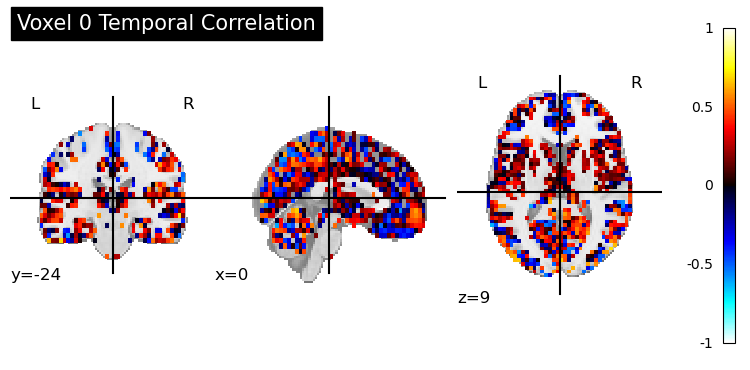

In [7]:
import nibabel as nib
from nilearn import plotting
# 원래 3D 공간에 상관계수 값을 반영
import matplotlib.pyplot as plt
shape = fmri_1.shape[:3]
correlation_3d = np.zeros(shape)
for i, coord in enumerate(nonzero_coords):
    correlation_3d[tuple(coord)] = corr_sub_1_vox_0[i]

# 결과 시각화
new_img = nib.Nifti1Image(correlation_3d, affine=fmri_1.affine)
plotting.plot_stat_map(new_img, title="Voxel 0 Temporal Correlation", display_mode='ortho')
plt.show()

In [8]:
nonzero_indices = np.where(common_nonzero_mask)[0]
print(f"Non-zero voxel indices: {nonzero_indices}")

Non-zero voxel indices: [    0     1     2 ... 14464 14465 14466]


In [9]:
def correlation_vector_to_3d_image(correlation_vector, common_nonzero_mask, reference_img):
    """
    Convert the correlation vector to a 3D image using the common non-zero mask.

    Parameters:
    - correlation_vector: 1D numpy array of correlation coefficients
    - common_nonzero_mask: 1D boolean numpy array indicating common non-zero voxels
    - reference_img: 3D or 4D reference image to get the shape and affine

    Returns:
    - correlation_img: 3D image with correlation values mapped to the original brain space
    """
    # Create an empty array with the same shape as the reference image
    correlation_data = np.zeros(reference_img.shape[:3])
     
    # Fill the non-zero voxels with the correlation vector values
    correlation_data[common_nonzero_mask.reshape(reference_img.shape[:3])] = correlation_vector

    # Create a new image using the correlation data
    correlation_img = new_img_like(reference_img, correlation_data)

    return correlation_img

In [15]:
from nilearn.image import resample_to_img, new_img_like, index_img
from nilearn import image, masking, plotting
correlation_vector=corr_sub_1_vox_0,
common_nonzero_mask=common_nonzero_mask,
reference_img=index_img(fmri_1,0)

print(reference_img.shape)

# Create an empty array with the same shape as the reference image
correlation_data = np.zeros(reference_img.shape)
 
# Fill the non-zero voxels with the correlation vector values
correlation_data[common_nonzero_mask.reshape(reference_img.shape[:3])] = correlation_vector

# Create a new image using the correlation data
correlation_img = new_img_like(reference_img, correlation_data)


# 3D 이미지 플롯
plotting.plot_stat_map(correlation_img, title="Temporal Correlation at Voxel[0]", display_mode='ortho', cut_coords=(0, 0, 0), draw_cross=True, annotate=False)
plt.show()

(42, 52, 35)


AttributeError: 'tuple' object has no attribute 'reshape'